<a href="https://colab.research.google.com/github/janpeter19/BPL_YEAST_COB_Batch/blob/main/BPL_YEAST_COB_Batch_fmpy_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BPL_TEST2_Batch script with FMPy

The key library FMPy is installed.

After the installation a small application BPL_YEAST_COB_Batch is loaded and run. You can continue with this example if you like.

In [ ]:
!lsb_release -a # Actual VM Ubuntu version used by Google

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.2 LTS
Release:	22.04
Codename:	jammy


In [ ]:
%env PYTHONPATH=

env: PYTHONPATH=


In [ ]:
!wget https://repo.anaconda.com/miniconda/Miniconda3-py310_23.1.0-1-Linux-x86_64.sh
!chmod +x Miniconda3-py310_23.1.0-1-Linux-x86_64.sh
!bash ./Miniconda3-py310_23.1.0-1-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.10/site-packages/')

--2023-09-13 05:35:56--  https://repo.anaconda.com/miniconda/Miniconda3-py310_23.1.0-1-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74403966 (71M) [application/x-sh]
Saving to: ‘Miniconda3-py310_23.1.0-1-Linux-x86_64.sh’

Miniconda3-py310_23 100%[===================>]  70.96M   184MB/s    in 0.4s    

2023-09-13 05:35:57 (184 MB/s) - ‘Miniconda3-py310_23.1.0-1-Linux-x86_64.sh’ saved [74403966/74403966]

PREFIX=/usr/local
Unpacking payload ...

Installing base environment...





Preparing transaction: - \ | / - \ | / done
Executing transaction: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done
installation finished.


In [ ]:
!conda update -n base -c defaults conda --yes

Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - conda


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boltons-23.0.0             |  py310h06a4308_0         430 KB
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.7.22          |  py310h06a4308_0         153 KB
    conda-23.7.4               |  py310h06a4308_0         1.0 MB
    conda-package-handling-2.2.0|  py310h06a4308_0         268 KB
    conda-package-streaming-0.9.0|  py310h06a4308_0          27 KB
    cryptography-41.0.3        |  py310hdda0065_0         2.0 MB
    jsonpatch-1.32             |     pyhd3eb1b0_0          15 KB
    jsonpointer-2.1            |     pyhd3eb1b0

In [ ]:
!conda --version
!python --version

conda 23.7.4
Python 3.10.13


In [ ]:
!conda install -c conda-forge fmpy --yes # Install the key package

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

In [ ]:
!conda install matplotlib --yes

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotli-1.0.9               |       he6710b0_2         375 KB
    contourpy-1.0.5            |  py

In [ ]:
#!conda install scipy --yes

In [ ]:
#!conda install xlrd --yes

In [ ]:
#!conda install openpyxl --yes

In [ ]:
# For some reason conda installation does not work for optlang
!pip install optlang

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 19.7 MB/s eta 0:00:00


# BPL_YEAST_COB_Batch setup


Now specific installation and the run simulations. Start with connecting to Github. Then upload the two files:

* FMU - BPL_YEAST_COB_Batch_linux_om_me.fmu
* Setup-file - BPL_YEAST_COB_Batch_fmpy_explore.py

In [ ]:
%%bash
git clone https://github.com/janpeter19/CONF_2023_10_MODELICA15

Cloning into 'CONF_2023_10_MODELICA15'...


In [ ]:
%cd CONF_2023_10_MODELICA15

/content/BPL_YEAST_COB_Batch/CONF_2023_10_MODELICA15


In [ ]:
run -i BPL_YEAST_COB_Batch_fmpy_explore.py

Linux - run FMU pre-comiled OpenModelica 1.21.0

Model for bioreactor has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values/units

Note that both disp() and describe() takes values from the last simulation
and the command process_diagram() brings up the main configuration

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [25/2.54, 20/2.54]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## BPL_YEAST_COB_Batch - demo



In [ ]:
from optlang import Model, Variable, Constraint, Objective

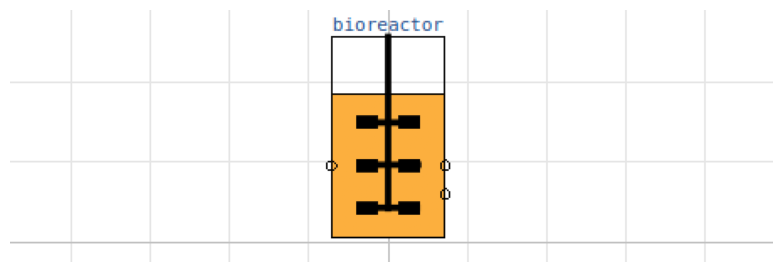

In [ ]:
process_diagram()

In [ ]:
describe('culture'); print(); #describe('liquidphase')                                  # Pump schedule parameter


Saccharomyces cerevisae - default parameters for strain H1022



In [ ]:
# Define culture constraint-based model
def culture(G, E):

    # LP calculation of the optimal qGr, qEr based on G and E values

    # - parameters
    qO2max = 6.9e-3; kog = 2.3; koe = 1.6; YGr = 3.5; YEr = 1.32;
    alpha = 0.01; beta = 1.0

    # - transfer data from dynamic reactor model to static LP model
    qGr_opt = Variable('qGr_opt', lb=0)
    qEr_opt = Variable('qEr_opt', lb=0)

    # - LP model constraint and objective
    mu_max = Objective(YGr*qGr_opt + YEr*qEr_opt, direction='max')
    qO2lim = Constraint(kog*qGr_opt + koe*qEr_opt, ub=qO2max)
    qGlim = Constraint(qGr_opt, ub=alpha*max(0,G))
    qElim = Constraint(qEr_opt, ub=beta*max(0,E))

    # - put together the LP model
    yeast_model = Model(name='Yeast bottleneck model')
    yeast_model.objective = mu_max
    yeast_model.add(qO2lim)
    yeast_model.add(qGlim)
    yeast_model.add(qElim)

    # - do LP optimization
    yeast_model.optimize()

    return (yeast_model.objective.value, yeast_model.variables.qGr_opt.primal, yeast_model.variables.qEr_opt.primal, qO2lim.primal)

In [ ]:
# Initialization
V_0=1.0
init(V_0=V_0, VX_0=V_0*2.0, VG_0=V_0*10, VE_0=3.0)

In [ ]:
# Loop of simulations
t_final = 8.0
t_samp = 0.0333
n_samp = t_final/t_samp + 1

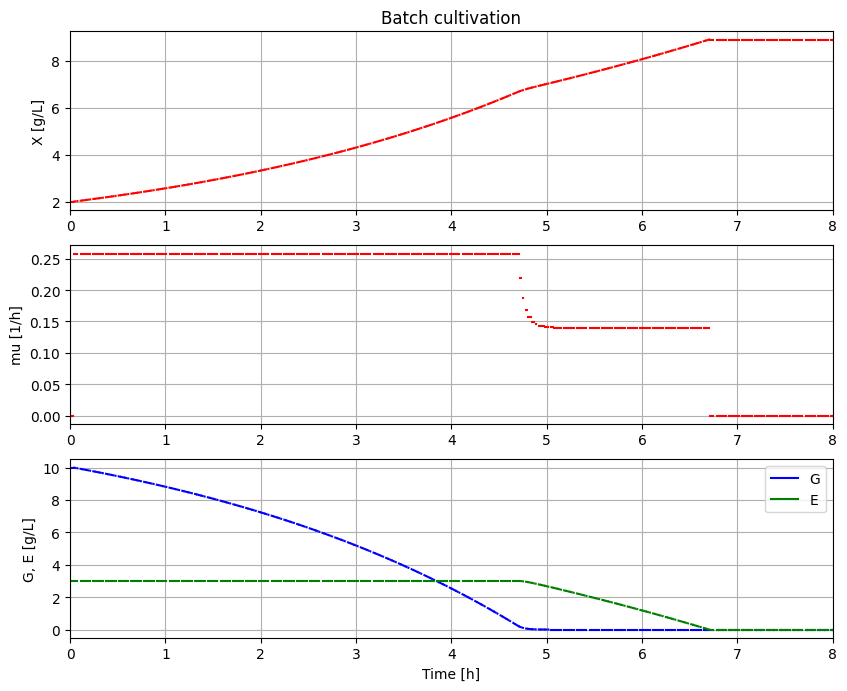

In [ ]:
# Simulate n sample steps
newplot(title='Batch cultivation', plotType='TimeSeries2')
ax1.set_xlim([0, t_final]); ax2.set_xlim([0, t_final]); ax3.set_xlim([0, t_final])

simu(t_samp, options=opts_fast)
for i in range(int(n_samp)):
    (mum_opt, qGr_opt, qEr_opt, qO2_opt) = culture(sim_res['bioreactor.c[2]'][-1], sim_res['bioreactor.c[3]'][-1])
    par(mum=mum_opt, qGr=qGr_opt, qEr=qEr_opt, qO2=qO2_opt)
    simu(t_samp, 'cont', options=opts_fast)

In [ ]:
system_info()


System information
 -OS: Linux
 -Python: 3.10.12
 -Scipy: not installed in the notebook
 -FMPy: 0.3.15
 -FMU by: OpenModelica Compiler OpenModelica 1.21.0
 -FMI: 2.0
 -Type: ME
 -Name: BPL_YEAST_COB.Batch
 -Generated: 2023-05-31T09:43:28Z
 -MSL: 3.2.3
 -Description: Bioprocess Library version 2.1.1
 -Interaction: FMU-explore for FMPy version 0.9.8


In [ ]:
!conda list optlang

# packages in environment at /usr/local:
#
# Name                    Version                   Build  Channel
optlang                   1.7.0                    pypi_0    pypi
